# <center>Regularization in Neural Network</center>
<center>Shan-Hung Wu & DataLab<br/>Fall 2016</center>

In [52]:
from IPython.display import Image
from IPython.display import display

# inline plotting instead of popping out
%matplotlib inline

# load utility classes/functions that has been taught in previous labs
# e.g., plot_decision_regions()
import os, sys
module_path = os.path.abspath(os.path.join('.'))
sys.path.append(module_path)
from lib import *

Deep neural network with a large number of parameters is a powerful machine learning system, but over-fitting is a serious issues in such networks. Deep neural network contains many non-linear hidden units and thus they can express very complicated relationships between their inputs and outputs. With limited training data, many of these relationships will be the result of sampling noise, so these relationships exist only on the training dataset, but not on the testing dataset. Large networks are slow, so it's hard for us to deal with the over-fitting issues by training several networks with different architecture and combine their outputs.
In this lab, we are going to talk about regularization in neural network.
We will introduce some common regularization methods in deep neural network today, which is 
* Dropout
* Weight Decay
* Maxout
* Noise

We will use the CIFAR-10 dataset today for our experiment. [CIFAR-10]() is a object recognition dataset of 10 class. The CIFAR-10 dataset consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 


The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 

Here are the classes in the dataset, as well as 10 random images from each:
<img src="fig-cifar-10.png" width="400">



# Loading and Preprocess the CIFAR-10 Dataset

## Load Data
Set the path for storing the dataset on your machine.

In [53]:
import os
from os.path import expanduser
home = expanduser('~')
data_path = os.path.join(home, "data/CIFAR-10/")
data_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

Set the constants for processing the dataset.

In [54]:
# the width and height of out image
img_size = 32
# number of channels: red, green and blue
img_channels = 3
# length of the image after we flatten the image into a 1-dim array
img_size_flat = img_size * img_size * img_channels
# number of classes
nb_classes = 10
# number of files in the training dataset
nb_files_train = 5
# number of images for each batch-file in the training-set.
images_per_file = 10000
# number of all the images in the training dataset
nb_images_train = nb_files_train * images_per_file

Download and extract the file. 

In [55]:
import os
# filename for saving the file downloaded from the internet.
filename = 'cifar-10-batches-py/'
file_path = os.path.join(data_path, filename)

# if the file exists then we assume it has also been extracted,
# otherwise we need to download and extract it now.
if not os.path.exists(file_path):
    # check if the download directory exists, otherwise create it.
    if not os.path.exists(data_path):
        os.makedirs(data_path)

    # download the file from the internet.
    file_path, _ = urllib.request.urlretrieve(url=data_url,
                                              filename=os.path.join(data_path, 'cifar-10-python.tar.gz'),
                                              reporthook=_print_download_progress)
    print("Download finished. Extracting files.")

    if file_path.endswith(".zip"):
        zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
    elif file_path.endswith((".tar.gz", ".tgz")):
        tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

    print("Done.")
else:
    print("Data has already been downloaded and unpacked.")

Data has already been downloaded and unpacked.


Load the classes name in the CIFAR-10 dataset from the metafile.

In [56]:
import pickle

file_path = os.path.join(data_path, "cifar-10-batches-py/", "batches.meta")

print("Loading data: " + file_path)
# b means open file in binary mode
with open(file_path, mode='rb') as file:
    # remember to set the encoding of th file
    data = pickle.load(file, encoding='bytes')

raw = data[b'label_names']

# convert from binary strings.
class_names = [x.decode('utf-8') for x in raw]
# class_names a list with the names.
class_names

Loading data: /home/greyjoy/data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [57]:
import numpy as np
from keras.utils import np_utils
def load_data(file_name):
    """
    Load a pickled data-file from the CIFAR-10 data-set
    and return the converted and the class-number
    for each image.
    """

    file_path = os.path.join(data_path, "cifar-10-batches-py/", file_name)

    print("Loading data: " + file_path)

    with open(file_path, mode='rb') as file:    
        data = pickle.load(file, encoding='bytes')

    raw_images = data[b'data']

    # get the class-numbers for each image. Convert to numpy-array.
    cls = np.array(data[b'labels'])

    # convert the raw images from the data-files to floating-points.
    raw_float = np.array(raw_images, dtype=float) / 255.0

    # reshape the array to a 4-dim array with shape: [image_number, channel, height, width] where the pixels are floats between 0.0 and 1.0.
    images = raw_float.reshape([-1, img_channels, img_size, img_size])

    return images, cls

def load_training_data():
    """
    Load all the training-data for the CIFAR-10 data-set.
    The data-set is split into 5 data-files which are merged here.
    Returns the images, class-numbers and one-hot encoded class-labels.
    """

    # pre-allocate the arrays for the images and class-numbers for efficiency.
    images = np.zeros(shape=[nb_images_train, img_channels, img_size, img_size], dtype=float)
    cls = np.zeros(shape=[nb_images_train], dtype=int)

    # begin-index for the current batch.
    begin = 0

    for i in range(nb_files_train):
        
        images_batch, cls_batch = load_data(file_name="data_batch_" + str(i + 1))
        num_images = len(images_batch)

        # End-index for the current batch.
        end = begin + num_images

        # store the images and class-numbers into the array.
        images[begin:end, :] = images_batch
        cls[begin:end] = cls_batch

        # The begin-index for the next batch is the current end-index.
        begin = end

    return images, cls, np_utils.to_categorical(cls, nb_classes)
X_train, cls_train, y_train = load_training_data()

Loading data: /home/greyjoy/data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: /home/greyjoy/data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: /home/greyjoy/data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: /home/greyjoy/data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: /home/greyjoy/data/CIFAR-10/cifar-10-batches-py/data_batch_5


Load the testing dataset using similar method

In [58]:
def load_test_data():
    """
    Load all the test-data for the CIFAR-10 data-set.
    Returns the images, class-numbers and one-hot encoded class-labels.
    """

    images, cls = load_data(file_name="test_batch")

    return images, cls, np_utils.to_categorical(cls, nb_classes)
X_test, cls_test, y_test = load_test_data()

Loading data: /home/greyjoy/data/CIFAR-10/cifar-10-batches-py/test_batch


Print out the size of the training and testing set to check if everything is loaded correctly.

In [59]:
from sklearn.model_selection import train_test_split

# split out validation dataset from training dataset
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# check data dimension
print("Size of:")
print("- Training-set:\t\t{}".format(len(X_train)))
print("- Validation-set:\t{}".format(len(X_valid)))
print("- Test-set:\t\t{}".format(len(X_test)))

Size of:
- Training-set:		40000
- Validation-set:	10000
- Test-set:		10000


Now our dataset is ready! Now I am going to introduce the architecture we will be working with today. 
Before, we have been working with regular neural network where each hidden layer is made up of a set of neurons, and each neuron is fully connected to all neurons in the previous layer.
Fully-connected neural network does’t do well on images. In CIFAR-10, images are only of size 3x32x32 (32 wide, 32 high, 3 color channels), so a single fully-connected neuron in a first hidden layer of a regular Neural Network would have 3072 weights. This amount might still seems manageable, but what if today we want to working bigger imaage with size, e.g. 3*256*256, would lead to neurons that have 196,608 weights. Moreover, we usually will have at least a few hundreds neurons for one layer and several layers. The weights add up very quickly this way! Therefore, it will take a long time to train the model, and the model might have serious over fitting issues. Convolutional neural network helps us saving lots of parameter.


# Layers

The architecure follows the pattern INPUT -> [[CONV -> RELU]*N -> POOL?]*M -> [DENSE -> RELU]*K -> OUTPUT

* INPUT [3x32x32] will hold the raw pixel values of the image(img_channels, img_width, img_height)
* CONV layer will compute the output of neurons that are connected to local regions in the input, each computing a dot product between their weights and a small region they are connected to in the input volume. This may result in volume such as [32x32x12] if we decided to use 12 filters.
* RELU layer will apply an elementwise activation function, such as the $max(0,x)$ This leaves the size of the volume unchanged ([32x32x12]).
* POOL layer will perform a downsampling operation along the spatial dimensions (width, height), resulting in volume such as [16x16x12].
* FLATTEN layer will flatten the input_matrix into volumn [1x1x(number_of_elements_on_last_layer_output))]
* DENSE layer will map the input into volumn [1x1x(number_of_neuron_in_DENSE_layer)]. Each neuron in this layer will be connected to all the numbers in the previous volume.
* OUTPUT layer will compute the class scores, resulting in volume of size [1x1x10], where each numbers correspond to a class score, such as among the 10 categories of CIFAR-10. 


## Convolutional Layers
The CONV layer’s parameters consist of a set of filters with learnable weights. Every filter is small spatially (along width and height), but extends through the full depth of the input volume. During the forward pass, we slide each filter across the width and height of the input volume and compute dot products between the entries of the filter and the input at any position. As we slide the filter over the width and height of the input volume we will produce a 2-dimensional activation map that gives the responses of that filter at every spatial position. Intuitively, the network will learn filters that activate when they see some type of visual feature such as an edge of some orientation or a blotch of some color on the first layer, or contour on higher layers of the network. Now, we will have an entire set of filters in each CONV layer (e.g. 12 filters), and each of them will produce a separate 2-dimensional activation map. We will stack these activation maps along the depth dimension and produce the output volume.

When dealing with high-dimensional inputs such as images, as we saw above it is impractical to connect neurons to all neurons in the previous volume. Instead, we will connect each neuron to only a local region of the input volume. The spatial extent of this connectivity is a hyper-parameter called the receptive field of the neuron (equivalently this is the filter size). The extent of the connectivity along the depth axis is always equal to the depth of the input volume. The connections are local in space (along width and height), but always full along the entire depth of the input volume.
<img src="fig-volumn.png" width="800">
<img src="fig-spatial-arrangement.png" width="800">

# Pooling layers
It is common to insert a Pooling layer between convolutional layers in a convolutional neural network architecture. Its function is to reduce the spatial size of the representation to reduce the amount of parameters and computation in the network. A pooling layer with filters of size 2x2 applied with a stride of 2 downsamples every depth slice in the input by 2 along both width and height by Max operation, discarding 75% of the activations. 
here is a figure explaining how pooling layers works:
<img src="fig-maxpooling.png" width="800">

In [60]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, GaussianNoise, MaxoutDense
from keras.constraints import maxnorm
from keras.regularizers import l1, l2
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import sys
import os
import time

# here are some settings for the network
batch_size = 32
nb_epoch = 25


model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(3, 32, 32), activation='relu', border_mode='same'))
model.add(Convolution2D(32, 3, 3, activation='relu', border_mode='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, 3, 3, activation='relu', border_mode='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(128, 3, 3, activation='relu', border_mode='same'))
model.add(Convolution2D(128, 3, 3, activation='relu', border_mode='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# flatten the input for feeding into Dense layer
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
# output layer
model.add(Dense(nb_classes, activation='softmax'))

# compile model
lrate = 0.01
decay = lrate/nb_epoch
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
# this is a useful function for inspecting the output shape and the number of parameter of the model
print(model.summary())

start = time.time()
his = model.fit(X_train, y_train, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_data=(X_valid, y_valid), \
          shuffle=True) \

# evaluate our model
score = model.evaluate(X_test, y_test, verbose=1)
print('\nTraining time: %f sec' % float(time.time()-start_time))
print('Test loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_81 (Convolution2D) (None, 32, 32, 32)    896         convolution2d_input_17[0][0]     
____________________________________________________________________________________________________
convolution2d_82 (Convolution2D) (None, 32, 32, 32)    9248        convolution2d_81[0][0]           
____________________________________________________________________________________________________
maxpooling2d_49 (MaxPooling2D)   (None, 32, 16, 16)    0           convolution2d_82[0][0]           
____________________________________________________________________________________________________
convolution2d_83 (Convolution2D) (None, 64, 16, 16)    18496       maxpooling2d_49[0][0]            
___________________________________________________________________________________________

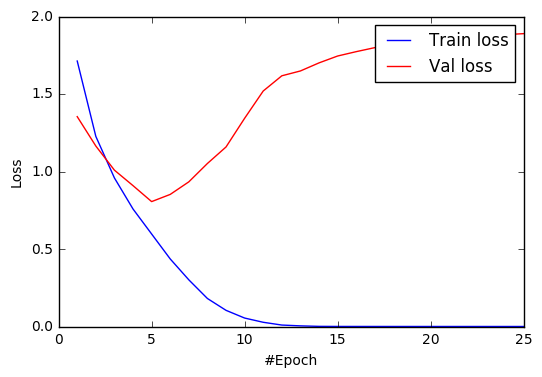

In [61]:
plot_validation_history(his, './output/fig-nn-val-baseline.png')

Apparently we are having the issues of over fitting here. It's a chance for us to learn some regularizations technique here.

# Dropout
Dropout is designed by Geoffrey Hinton.
The key idea is to randomly drop some units from the neural network during training, so that the neuron have to function well on its own instead of relying on other neurons. (Just like when you know your teammate is not that reliable, you have to take more responsibility)
In a standard neural network, the derivative received by each parameter tells it how it should change so the final loss function is reduced, given what all other units are doing. Therefore, units may change in a way that they fix up the mistakes of the other units. This may lead to complex co-adaptations.
Applying dropout to a neural network amounts to sampling a “thinned” network from it. The thinned network consists of all the units that are not dropped out (Figure b). A neural net with $n$ units, can be seen as a collection of  possible thinned neural networks. For each presentation of each training case, a new thinned network is sampled and trained.

The following figures illustrate the architecture:

<img src="fig-dropout.png" width="600">
<img src="fig-ensemble-of-subnetworks.png" width="600">


The choice of which units to drop is random. In the simplest case, each unit is retained with a fixed probability $p$ independent of other units, where $p$ can be chosen using a validation set or can simply be set at 0.5, which seems to be close to optimal for a wide range of networks and tasks.
At test time, it is not feasible to explicitly average the predictions from exponentially many thinned models. A very simple approximate averaging method works well in practice. The idea is to use a single neural net at test time **without dropout**. If a unit is retained with probability $p$ during training, the outgoing weights of that unit are multiplied by $p$ at test time as shown in the figure below. This is to ensure that for any hidden unit the expected output (under the distribution used to drop units at training time) is the same as the actual output at test time.
<img src="fig-weight.png" width="600">

Let's wrap our code into a function with all kinds of regularization method, also, we plug in max pooling layer between convolutional layer

In [38]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, GaussianNoise, MaxoutDense
from keras.constraints import maxnorm
from keras.regularizers import l1, l2
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import sys
import os
import time


# here are some settings for the network
batch_size = 32
nb_epoch = 25

def gen_nn(dropout=False, maxout=False, weight_constraint=False, l2_reg=False, l2_coef=0.1, l1_reg=False, l1_coef=0.005):
    """
    Create a model according to the specification.
    """
        
    model = Sequential()
    model.add(Convolution2D(32, 3, 3, input_shape=(3, 32, 32), activation='relu', border_mode='same'))
    if dropout:
        model.add(Dropout(0.2))
    model.add(Convolution2D(32, 3, 3, activation='relu', border_mode='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if dropout:
        model.add(Dropout(0.2))
    model.add(Convolution2D(64, 3, 3, activation='relu', border_mode='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(128, 3, 3, activation='relu', border_mode='same'))
    if dropout:
        model.add(Dropout(0.2))
    model.add(Convolution2D(128, 3, 3, activation='relu', border_mode='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    
    if dropout:
        model.add(Dropout(0.2))
        
    if l2_reg:
        model.add(Dense(1024, activation='relu', W_regularizer=l2(l2_coef)))  
    elif l1_reg:
        model.add(Dense(1024, activation='relu', W_regularizer=l1(l1_coef)))          
    elif weight_constraint:
        model.add(Dense(1024, activation='relu', W_constraint=maxnorm(3)))
    elif maxout:
        model.add(MaxoutDense(1024, nb_feature=2, init='glorot_uniform'))
    else:
        model.add(Dense(1024, activation='relu'))

    if dropout:
        model.add(Dropout(0.25))
        
    if l2_reg:
        model.add(Dense(512, activation='relu', W_regularizer=l2(l2_coef)))  
    elif l1_reg:
        model.add(Dense(512, activation='relu', W_regularizer=l1(l1_coef)))         
    elif weight_constraint:
        model.add(Dense(512, activation='relu', W_constraint=maxnorm(3)))
    elif maxout:
        model.add(MaxoutDense(512, nb_feature=4, init='glorot_uniform'))
    else:
        model.add(Dense(512, activation='relu'))
        
    if dropout:
        model.add(Dropout(0.25))
    # output layer    
    model.add(Dense(nb_classes, activation='softmax'))
    # compile model
    lrate = 0.01
    decay = lrate/nb_epoch
    sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

In [39]:
dropout_model = gen_nn(dropout=True)
start = time.time()
dropout_his = dropout_model.fit(X_train, y_train, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_data=(X_valid, y_valid), \
          shuffle=True) \

# evaluate our model
score = dropout_model.evaluate(X_test, y_test, verbose=0)
print('\nTraining time: %f sec' % float(time.time()-start_time))
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

Train on 40000 samples, validate on 10000 samples
Epoch 1/25
40000/40000 [==============================] - 8s - loss: 1.9043 - acc: 0.2902 - val_loss: 1.7575 - val_acc: 0.3677
Epoch 2/25
40000/40000 [==============================] - 7s - loss: 1.5078 - acc: 0.4488 - val_loss: 1.3866 - val_acc: 0.4991
Epoch 3/25
40000/40000 [==============================] - 7s - loss: 1.3424 - acc: 0.5125 - val_loss: 1.2576 - val_acc: 0.5486
Epoch 4/25
40000/40000 [==============================] - 7s - loss: 1.2169 - acc: 0.5613 - val_loss: 1.1048 - val_acc: 0.6065
Epoch 5/25
40000/40000 [==============================] - 7s - loss: 1.1067 - acc: 0.6044 - val_loss: 1.0343 - val_acc: 0.6309
Epoch 6/25
40000/40000 [==============================] - 8s - loss: 1.0176 - acc: 0.6359 - val_loss: 0.9710 - val_acc: 0.6555
Epoch 7/25
40000/40000 [==============================] - 8s - loss: 0.9406 - acc: 0.6667 - val_loss: 0.9289 - val_acc: 0.6788
Epoch 8/25
40000/40000 [==============================] - 7s 

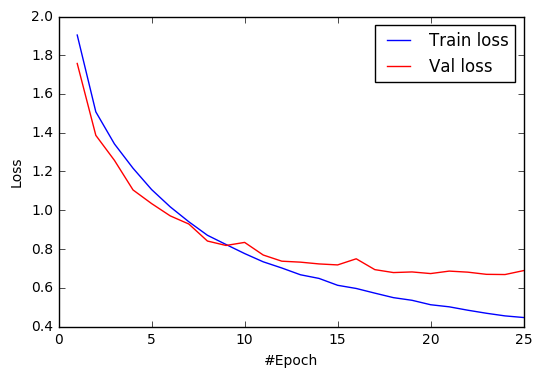

In [40]:
plot_validation_history(dropout_his, './output/fig-nn-val-dropout.png')

We can see the dropout has a signifanct effect on the result!

# Weight Decay
Remember we talked about weight decay before? We can penalize large weights using penalties or constraints on their squared values (L2 penalty) or absolute values (L1 penalty).
We specify in l1/l2 regularities by passing a regularizer to the layer.
```
from keras.regularizers import l1, l2 
model.add(Dense(64, input_dim=64, W_regularizer=l2(0.01)))
```


## L2 Regularizer

This can often improve generalization a lot because it helps to stop the network from fitting the sampling error and it makes a smoother model in which the output changes more slowly as the input changes.

We can gain some insight into the behavior of weight decay regularization by studying the gradient of the regularized objective function. To simplify the presentation, we assume no bias parameter. Such a model has the following total objective function:

$$\tilde{J}(\mathbf{w};\mathbf{X},\mathbf{y})==\frac{\alpha}{2}\mathbf{w}^{T}\mathbf{w}+J(\mathbf{w};\mathbf{X},\mathbf{y}),$$

with the corresponding parameter gradient

$$\text{∇}_{\mathbf{w}}\tilde{J}(\mathbf{w};\mathbf{X},\mathbf{y})=α\mathbf{w}+\text{∇}_{\mathbf{w}}J(\mathbf{w};\mathbf{X},\mathbf{y}).$$

To take a single gradient step to update the weights, we perform this update:

$$\mathbf{w}←\mathbf{w}−(α\mathbf{w}+∇_{\mathbf{w}}J(\mathbf{w};\mathbf{X},\mathbf{y})).$$

Written another way, the update is: 

$$\mathbf{w}←(1−α)\mathbf{w}−∇_{\mathbf{w}}J(\mathbf{w};\mathbf{X},\mathbf{y})\Theta$$

We can see that the addition of the weight decay term has modiﬁed the learning
rule to multiplicatively shrink the weight vector by a constant factor on each step,
just before performing the usual gradient update.

In [42]:
l2_model = gen_nn(l2_reg=True, l2_coef=0.005)
start = time.time()
l2_his = l2_model.fit(X_train, y_train, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_data=(X_valid, y_valid), \
          shuffle=True) \

# evaluate our model
score = l2_model.evaluate(X_test, y_test, verbose=1)
print('\nTraining time: %f sec' % float(time.time()-start_time))
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])

Train on 40000 samples, validate on 10000 samples
Epoch 1/25
40000/40000 [==============================] - 11s - loss: 6.0506 - acc: 0.3113 - val_loss: 1.5053 - val_acc: 0.4510
Epoch 2/25
40000/40000 [==============================] - 11s - loss: 2.1658 - acc: 0.4984 - val_loss: 1.2993 - val_acc: 0.5329
Epoch 3/25
40000/40000 [==============================] - 11s - loss: 1.4839 - acc: 0.5772 - val_loss: 1.1427 - val_acc: 0.5906
Epoch 4/25
40000/40000 [==============================] - 11s - loss: 1.2290 - acc: 0.6355 - val_loss: 1.0572 - val_acc: 0.6311
Epoch 5/25
40000/40000 [==============================] - 11s - loss: 1.0837 - acc: 0.6848 - val_loss: 0.9553 - val_acc: 0.6640
Epoch 6/25
40000/40000 [==============================] - 11s - loss: 0.9692 - acc: 0.7288 - val_loss: 0.9551 - val_acc: 0.6704
Epoch 7/25
40000/40000 [==============================] - 11s - loss: 0.8740 - acc: 0.7702 - val_loss: 0.9159 - val_acc: 0.6903
Epoch 8/25
40000/40000 [==============================

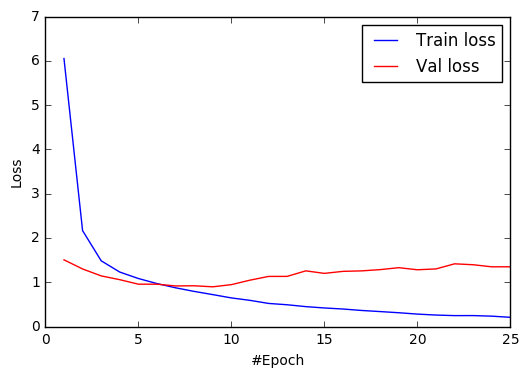

In [43]:
plot_validation_history(l2_his, './output/fig-nn-val-l2.png')

L2 is working, too!

##  L1 Regularizer

In [44]:
l1_model = gen_nn(l1_reg=True, l1_coef=0.001)
start = time.time()
l1_his = l1_model.fit(X_train, y_train, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_data=(X_valid, y_valid), \
          shuffle=True) \

# evaluate our model
score = l1_model.evaluate(X_test, y_test, verbose=1)
print('\nTraining time: %f sec' % float(time.time()-start_time))
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])


Train on 40000 samples, validate on 10000 samples
Epoch 1/25
40000/40000 [==============================] - 11s - loss: 11.2147 - acc: 0.2627 - val_loss: 1.8007 - val_acc: 0.3214
Epoch 2/25
40000/40000 [==============================] - 11s - loss: 1.7757 - acc: 0.3833 - val_loss: 1.5378 - val_acc: 0.4327
Epoch 3/25
40000/40000 [==============================] - 11s - loss: 1.5659 - acc: 0.4592 - val_loss: 1.3889 - val_acc: 0.4854
Epoch 4/25
40000/40000 [==============================] - 11s - loss: 1.4130 - acc: 0.5207 - val_loss: 1.2146 - val_acc: 0.5652
Epoch 5/25
40000/40000 [==============================] - 11s - loss: 1.2730 - acc: 0.5773 - val_loss: 1.0726 - val_acc: 0.6121
Epoch 6/25
40000/40000 [==============================] - 11s - loss: 1.1556 - acc: 0.6236 - val_loss: 1.0531 - val_acc: 0.6254
Epoch 7/25
40000/40000 [==============================] - 11s - loss: 1.0780 - acc: 0.6526 - val_loss: 0.9920 - val_acc: 0.6488
Epoch 8/25
40000/40000 [=============================

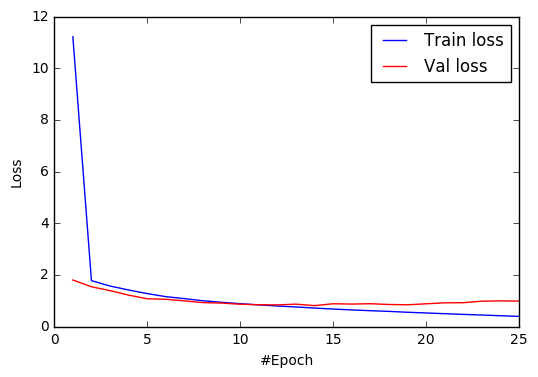

In [45]:
plot_validation_history(l1_his, './output/fig-nn-val-l1.png')

# Maxout
Maxout is called maxout because its output is the max of a set of inputs. It wasa designed by Goodfellow on January 2013. 
You can simply create a dense layer with maxout by calling the MaxoutDense layer in Keras.
A MaxoutDense layer takes the element-wise maximum of nb_feature Dense(input_dim, output_dim) linear layers. This allows the layer to learn a convex, piecewise linear activation function over the inputs.
Given an input $v\subseteq\mathbb{R}^{d}$, a maxout hidden layer implements the function $h_{i}(x)=\underset{j\subseteq[1,k]}{max}z_{ij}$, where $z_{ij}=x^{T}W_{\text{···}ij}+b_{ij}$, and $W\subseteq\mathbb{R}^{d\times m\times k}$and $b\subseteq\mathbb{R}^{m\times k}$
<img src="fig-maxout.png" width="600">

Train on 40000 samples, validate on 10000 samples
Epoch 1/25
40000/40000 [==============================] - 11s - loss: 1.8744 - acc: 0.3062 - val_loss: 1.4899 - val_acc: 0.4551
Epoch 2/25
40000/40000 [==============================] - 11s - loss: 1.4324 - acc: 0.4783 - val_loss: 1.2727 - val_acc: 0.5412
Epoch 3/25
40000/40000 [==============================] - 11s - loss: 1.2273 - acc: 0.5580 - val_loss: 1.1351 - val_acc: 0.5917
Epoch 4/25
40000/40000 [==============================] - 11s - loss: 1.0623 - acc: 0.6214 - val_loss: 0.9805 - val_acc: 0.6555
Epoch 5/25
40000/40000 [==============================] - 11s - loss: 0.9566 - acc: 0.6581 - val_loss: 0.8978 - val_acc: 0.6881
Epoch 6/25
40000/40000 [==============================] - 11s - loss: 0.8682 - acc: 0.6918 - val_loss: 0.8091 - val_acc: 0.7173
Epoch 7/25
40000/40000 [==============================] - 11s - loss: 0.8049 - acc: 0.7129 - val_loss: 0.7556 - val_acc: 0.7405
Epoch 8/25
40000/40000 [==============================

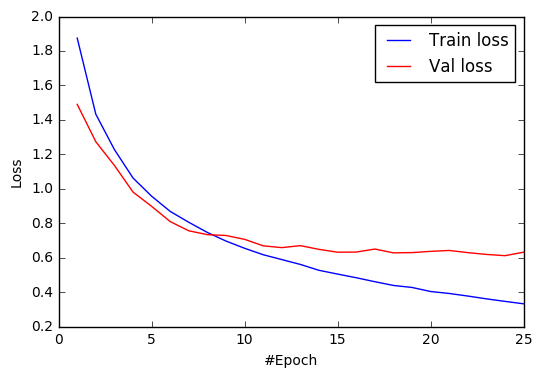

In [46]:
maxout_model = gen_nn(maxout=True, dropout=True)
start = time.time()
maxout_his = maxout_model.fit(X_train, y_train, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_data=(X_valid, y_valid), \
          shuffle=True) \

# evaluate our model
score = maxout_model.evaluate(X_test, y_test, verbose=1)
print('\nTraining time: %f sec' % float(time.time()-start_time))
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(maxout_his, './output/fig-nn-val-maxout.png')

We can see maxout is helping dropout in this case.

# Noise
We can add noise to our data by data augmentation. We will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better. This skill is very useful especially when you have very little amount of data.
* rotation_range is a value in degrees (0-180), a range within which to randomly rotate pictures
* width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
* shear_range is for randomly applying shearing transformations
* zoom_range is for randomly zooming inside pictures
* horizontal_flip is for randomly flipping half of the images horizontally --relevant when there are no assumptions of horizontal assymetry (e.g. real-world pictures).
* fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Here are some sample images after data augmentation.
<img src="fig-data-augmentation.png" width="600">

In [47]:
from keras.preprocessing.image import ImageDataGenerator
base_model = gen_nn()

datagen = ImageDataGenerator(
        rotation_range=40, 
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
# fit-generator deosn't support validation_rate, so we have to split the validation data by ourself
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
start = time.time()
aug_his = base_model.fit_generator(datagen.flow(X_train, y_train,
                    batch_size=batch_size),
                    samples_per_epoch=X_train.shape[0],
                    nb_epoch=nb_epoch,
                    validation_data=(X_valid, y_valid))
# evaluate our model
score = base_model.evaluate(X_test, y_test, verbose=1)
print('\nTraining time: %f sec' % float(time.time()-start_time))
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])



Epoch 1/25
32000/32000 [==============================] - 10s - loss: 2.0131 - acc: 0.2538 - val_loss: 1.7239 - val_acc: 0.3724
Epoch 2/25
32000/32000 [==============================] - 10s - loss: 1.7223 - acc: 0.3751 - val_loss: 1.5159 - val_acc: 0.4534
Epoch 3/25
32000/32000 [==============================] - 10s - loss: 1.5775 - acc: 0.4253 - val_loss: 1.4196 - val_acc: 0.4793
Epoch 4/25
32000/32000 [==============================] - 10s - loss: 1.4838 - acc: 0.4612 - val_loss: 1.2686 - val_acc: 0.5399
Epoch 5/25
32000/32000 [==============================] - 10s - loss: 1.4081 - acc: 0.4922 - val_loss: 1.1990 - val_acc: 0.5654
Epoch 6/25
32000/32000 [==============================] - 10s - loss: 1.3395 - acc: 0.5162 - val_loss: 1.1306 - val_acc: 0.5975
Epoch 7/25
32000/32000 [==============================] - 10s - loss: 1.2963 - acc: 0.5332 - val_loss: 1.1082 - val_acc: 0.6038
Epoch 8/25
32000/32000 [==============================] - 10s - loss: 1.2495 - acc: 0.5533 - val_loss: 1

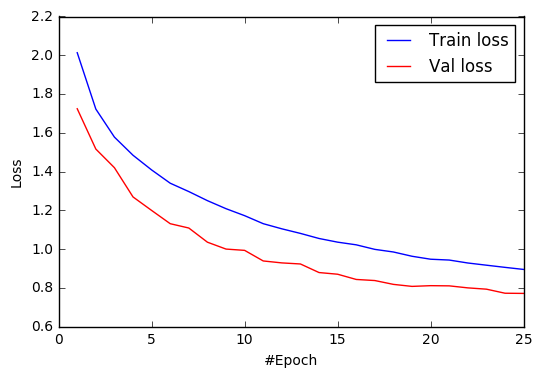

In [48]:
plot_validation_history(aug_his, './output/fig-nn-val-aug.png')

Now you've learned lots of techniques and layers to improve your model, good luck training!